In [1]:
from skimage import io, transform
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, DistributedSampler
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
from tensorboardX import SummaryWriter
import time


# Make folder to save model and tensorboard

In [197]:
date_folder='C:/Users/piyalong/TAMIDS_point/20230713/'

output_dir=os.path.join(date_folder,'out/')

tensorboard_dir=os.path.join(date_folder,'tensorboard/')
checkpoints_dir=os.path.join(date_folder,'ckpts/')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(tensorboard_dir):
    os.makedirs(tensorboard_dir)
if not os.path.exists(checkpoints_dir):
    os.makedirs(checkpoints_dir)

In [3]:
date_folder

'C:/Users/piyalong/TAMIDS_point/20230713/'

# Build Model

In [180]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Backbone_VGG(nn.Module):
    def __init__(self):
        super(Backbone_VGG, self).__init__()
        self.body1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.body2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.body3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.body4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        out1 = self.body1(x)
        out2 = self.body2(out1)
        out3 = self.body3(out2)
        out4 = self.body4(out3)
        
        return out1, out2, out3, out4


class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.conv1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act4 = nn.ReLU()
        self.output = nn.Conv2d(256, 8, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)
        out = self.conv2(out)
        out = self.act2(out)
        out = self.conv3(out)
        out = self.act3(out)
        out = self.conv4(out)
        out = self.act4(out)
        out = self.output(out)
        
        out = out.permute(0, 2, 3, 1)

        return out.contiguous().view(out.shape[0], -1, 2)


class ClassificationModel(nn.Module):
    def __init__(self, num_features_in=256, num_anchor_points=4, num_classes=2, prior=0.01, feature_size=256):
        super(ClassificationModel, self).__init__()

        self.num_classes = num_classes
        self.num_anchor_points = num_anchor_points

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchor_points * num_classes, kernel_size=3, padding=1)
        self.output_act = nn.Sigmoid()
        
    # sub-branch forward
    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.output(out)

        out1 = out.permute(0, 2, 3, 1)

        batch_size, width, height, _ = out1.shape

        out2 = out1.view(batch_size, width, height, self.num_anchor_points, self.num_classes)

        return out2.contiguous().view(x.shape[0], -1, self.num_classes)

class AnchorPoints(nn.Module):
    def __init__(self, pyramid_levels=None, strides=None, row=3, line=3):
        super(AnchorPoints, self).__init__()

        if pyramid_levels is None:
            self.pyramid_levels = [3, 4, 5, 6, 7]
        else:
            self.pyramid_levels = pyramid_levels

        if strides is None:
            self.strides = [2 ** x for x in self.pyramid_levels]

        self.row = row
        self.line = line

    def forward(self, image):
        image_shape = image.shape[2:]
        image_shape = np.array(image_shape)
        image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in self.pyramid_levels]

        all_anchor_points = np.zeros((0, 2)).astype(np.float32)
        # get reference points for each level
        for idx, p in enumerate(self.pyramid_levels):
            anchor_points = generate_anchor_points(2**p, row=self.row, line=self.line)
            shifted_anchor_points = shift(image_shapes[idx], self.strides[idx], anchor_points)
            all_anchor_points = np.append(all_anchor_points, shifted_anchor_points, axis=0)

        all_anchor_points = np.expand_dims(all_anchor_points, axis=0)
        # send reference points to device
        if torch.cuda.is_available():
            return torch.from_numpy(all_anchor_points.astype(np.float32)).cuda()
        else:
            return torch.from_numpy(all_anchor_points.astype(np.float32))
def generate_anchor_points(stride=16, row=3, line=3):
    row_step = stride / row
    line_step = stride / line

    shift_x = (np.arange(1, line + 1) - 0.5) * line_step - stride / 2
    shift_y = (np.arange(1, row + 1) - 0.5) * row_step - stride / 2

    shift_x, shift_y = np.meshgrid(shift_x, shift_y)

    anchor_points = np.vstack((
        shift_x.ravel(), shift_y.ravel()
    )).transpose()

    return anchor_points

def shift(shape, stride, anchor_points):
    shift_x = (np.arange(0, shape[1]) + 0.5) * stride
    shift_y = (np.arange(0, shape[0]) + 0.5) * stride

    shift_x, shift_y = np.meshgrid(shift_x, shift_y)

    shifts = np.vstack((
        shift_x.ravel(), shift_y.ravel()
    )).transpose()

    A = anchor_points.shape[0]
    K = shifts.shape[0]
    all_anchor_points = (anchor_points.reshape((1, A, 2)) + shifts.reshape((1, K, 2)).transpose((1, 0, 2)))
    all_anchor_points = all_anchor_points.reshape((K * A, 2))

    return all_anchor_points


class Decoder(nn.Module):
    def __init__(self, C3_size, C4_size, C5_size, feature_size=256):
        super(Decoder, self).__init__()

        # upsample C5 to get P5 from the FPN paper
        self.P5_1 = nn.Conv2d(C5_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P5_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P5_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P5 elementwise to C4
        self.P4_1 = nn.Conv2d(C4_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P4_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P4_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P4 elementwise to C3
        self.P3_1 = nn.Conv2d(C3_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P3_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P3_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)


    def forward(self, inputs):
        C3, C4, C5 = inputs

        P5_x = self.P5_1(C5)
        P5_upsampled_x = self.P5_upsampled(P5_x)
        P5_x = self.P5_2(P5_x)

        P4_x = self.P4_1(C4)
        P4_x = P5_upsampled_x + P4_x
        P4_upsampled_x = self.P4_upsampled(P4_x)
        P4_x = self.P4_2(P4_x)

        P3_x = self.P3_1(C3)
        P3_x = P3_x + P4_upsampled_x
        P3_x = self.P3_2(P3_x)

        return [P3_x, P4_x, P5_x]


class P2PNet(nn.Module):
    def __init__(self):
        super(P2PNet, self).__init__()
        self.backbone = Backbone_VGG()
        self.regression = RegressionModel()
        self.classification = ClassificationModel()
        self.anchor_points = AnchorPoints(pyramid_levels=[3,], row=2, line=2)
        self.fpn =  Decoder(256, 512, 512)

    def forward(self, x):
        features = self.backbone(x)
        features_fpn = self.fpn([features[1], features[2], features[3]])
        
        batch_size = features[0].shape[0]
        regression_out = regression(features_fpn[1]) * 100 # 8x
        classification_out = self.classification(features_fpn[1])
        anchor_points_out = self.anchor_points(x).repeat(batch_size, 1, 1)
        
        output_coord = regression_out.to(device) + anchor_points_out.to(device)
        
        output_class = classification_out
        out = {'pred_logits': output_class, 'pred_points': output_coord}
       
        return out


In [181]:
backbone(x)[0].shape

torch.Size([1, 128, 112, 112])

In [182]:
# Create an instance of the P2PNet model
model = P2PNet()

# Print the model architecture

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PATH='C:/Users/piyalong/CrowdCounting-P2PNet/weights/SHTechA.pth'
checkpoint = torch.load(PATH, map_location=device)
model.load_state_dict(checkpoint['model'])

model.to(device)

P2PNet(
  (backbone): Backbone_VGG(
    (body1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
    )
    (body2): Sequential(
      (0): MaxPool2d(ke

In [184]:
# Forward pass through the model
x = torch.randn(1, 3, 224, 224).to(device)
y = model(x)

In [212]:
x.size()

torch.Size([1, 3, 224, 224])

In [185]:
import torch
from torchviz import make_dot
from torchvision.models import resnet50

# Create an instance of the model
# model = resnet50()

# Forward pass through the model
x = torch.randn(1, 3, 224, 224).to(device)
# y = model(x)

backbone=Backbone_VGG().to(device)
backbone(x)[0].shape
features = model.backbone(x)
print(len(features))

features_fpn = model.fpn([features[1], features[2], features[3]])

print(features[0].shape)

batch_size = features[0].shape[0]
# run the regression and classification branch
regression=RegressionModel().to(device)
regression_out = regression(features_fpn[1]) * 100 # 8x
classification=ClassificationModel().to(device)
classification_out = classification(features_fpn[1])

anchor_points = AnchorPoints(pyramid_levels=[3,], row=2, line=2)
anchor_points_out = anchor_points(x).repeat(batch_size, 1, 1)


output_coord = regression_out.to(device) + anchor_points_out.to(device)
output_class = classification_out
out = {'pred_logits': output_class, 'pred_points': output_coord}

out

4
torch.Size([1, 128, 112, 112])


{'pred_logits': tensor([[[-0.0197,  0.0303],
          [ 0.0229,  0.0257],
          [ 0.0495,  0.0671],
          ...,
          [-0.0414,  0.0068],
          [ 0.0321,  0.1261],
          [-0.0092, -0.0035]]], device='cuda:0', grad_fn=<ViewBackward>),
 'pred_points': tensor([[[  1.6321,   3.7552],
          [  3.6792,   1.1808],
          [  3.3792,   6.7682],
          ...,
          [220.4503, 218.1567],
          [220.0538, 221.1366],
          [223.2200, 221.5525]]], device='cuda:0', grad_fn=<AddBackward0>)}

In [145]:
classification_out.shape

torch.Size([1, 3136, 2])

In [146]:
regression_out.shape

torch.Size([1, 3136, 2])

In [147]:
regression

RegressionModel(
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (output): Conv2d(256, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [148]:
classification

ClassificationModel(
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (output): Conv2d(256, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (output_act): Sigmoid()
)

In [149]:
len(features_fpn)

3

In [150]:
features_fpn[2].shape

torch.Size([1, 256, 14, 14])

# Custom Dataset

In [151]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [152]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.targets = []
        
        for filename in os.listdir(root_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                img_path = os.path.join(root_dir, filename)
                self.images.append(img_path)
                
                target = os.path.join(root_dir, filename[:-4]+'.txt')
                self.targets.append(target)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        assert idx <= len(self), 'index range error'
        img_path = self.images[idx]
        gt_path = self.targets[idx]
        
        image = io.imread(img_path)
        points = []
        with open(gt_path) as f_label:
            for line in f_label:
                x = float(line.strip().split(' ')[0])
                y = float(line.strip().split(' ')[1])
                points.append([x, y])
            
        sample = {'image': image, 'landmarks': np.array(points)}

        if self.transform:
            sample = self.transform(sample)
            
        return sample
    
    
datatransform = transforms.Compose([
                                   Rescale(256),
                                   # RandomCrop(1000),
                                   ToTensor()
                                           ])



In [153]:
dataset_train=CustomDataset('D:/20230426CDI/data/train/',datatransform)
data_loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)

In [154]:
dataset_test=CustomDataset('D:/20230426CDI/data/test/',datatransform)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=True)

In [155]:
len(data_loader_train)

90

In [156]:
len(dataset_train)

90

In [157]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    image_numpy = np.transpose(image, (1, 2, 0))
    image_numpy=image_numpy.numpy().copy() 
    plt.imshow(image_numpy)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=20, marker='s', c='y')
    plt.pause(0.001)  # pause a bit so that plots are updated

# plt.figure()
# show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
#                landmarks)
# plt.show()

0 torch.Size([3, 256, 256]) torch.Size([9, 2])


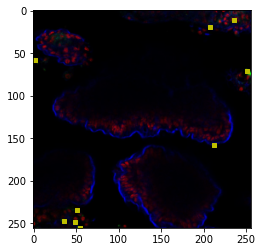

1 torch.Size([3, 256, 256]) torch.Size([11, 2])


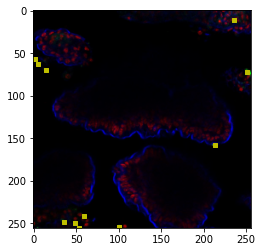

2 torch.Size([3, 256, 256]) torch.Size([12, 2])


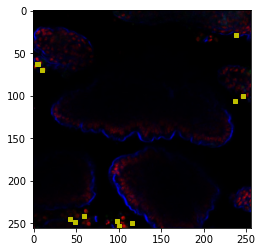

3 torch.Size([3, 256, 256]) torch.Size([14, 2])


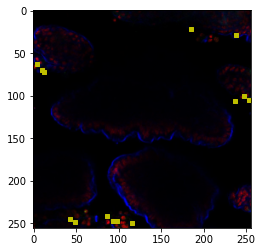

In [158]:
for i in range(len(dataset_test)):
    sample = dataset_test[i]

    print(i, sample['image'].size(), sample['landmarks'].size())
    show_landmarks(sample['image'],sample['landmarks'])   
    sample['landmarks']
    if i == 3:
        break

In [159]:
sample['landmarks']

tensor([[237.5000, 106.5000],
        [247.2500, 100.5000],
        [253.0000, 104.5000],
        [184.7500,  21.5000],
        [238.2500,  29.0000],
        [  3.5000,  62.2500],
        [  9.5000,  69.7500],
        [ 11.7500,  71.7500],
        [ 42.5000, 245.0000],
        [ 48.5000, 249.0000],
        [ 86.7500, 241.7500],
        [ 93.0000, 247.0000],
        [ 98.0000, 247.5000],
        [116.0000, 250.0000]], dtype=torch.float64)

0 torch.Size([1, 3, 256, 256]) torch.Size([1, 12, 2])
1 torch.Size([1, 3, 256, 256]) torch.Size([1, 12, 2])
2 torch.Size([1, 3, 256, 256]) torch.Size([1, 11, 2])
3 torch.Size([1, 3, 256, 256]) torch.Size([1, 5, 2])


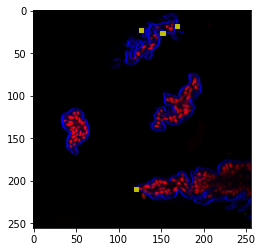

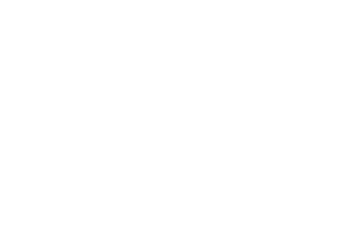

In [160]:
for i_batch, sample_batched in enumerate(data_loader_test):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())
    # observe 4th batch and stop.
    if i_batch == 3:
        for i in range(sample_batched['image'].shape[0]):
            plt.figure()
            show_landmarks(sample_batched['image'][i],sample_batched['landmarks'][i])
            plt.axis('off')
            plt.ioff()
            plt.show()
        break

In [161]:
sample_batched['image'].shape[0]

1

In [162]:
range(1)

range(0, 1)

# rewrite loss function

In [163]:
from scipy.optimize import linear_sum_assignment
import numpy as np
from scipy.spatial.distance import cdist

In [164]:
class Loss_function():
    def __init__(self, num_classes=2):
        self.num_classes = num_classes
        self.cost_matrixs = None
        
        
    def match(self,y_pred, y_true):
        self.cost_matrixs=[]
        indices=[]
        for predicted_points, gt_points in zip (y_pred, y_true):
            
            predicted_points= predicted_points.cpu().detach().numpy()

            gt_points = gt_points.cpu().detach().numpy()
            
            # print(predicted_points.shape, gt_points.shape)
            
            cost_matrix=cdist(predicted_points, gt_points, 'euclidean')
            self.cost_matrixs.append(cost_matrix)
            row_indices, col_indices = linear_sum_assignment(cost_matrix)

            indices.append([row_indices, col_indices])

        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]
    
    def loss_labels(self, outputs, y_true, indices, num_points):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']
        idx = self._get_src_permutation_idx(indices)
        # target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes_o=torch.ones([y_true.shape[1]]).long().to(device)
        target_classes = torch.full(src_logits.shape[:2], 0,
                                    dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o

        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes)

        # print('target_classes_o: {} \n target_classes.shape: {} \n loss_ce:{} \n idx:  {} src_logits.shape {}'.format(target_classes_o,target_classes.shape,loss_ce,idx,src_logits.shape))

        return loss_ce 

    def _get_src_permutation_idx( self,indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def loss_points(self, outputs, targets, indices, num_points):

        assert 'pred_points' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_points = outputs['pred_points'][idx].float()
        target_points = torch.cat([t[i] for t, (_, i) in zip(targets, indices)], dim=0).float().to(device)

        loss_bbox = F.mse_loss(src_points, target_points, reduction='none')

        # print('src_points{} ,target_points {},loss_bbox.sum() {}, num_points{}'.format( src_points,target_points,loss_bbox.sum(), num_points))
        return loss_bbox.sum() / num_points

In [165]:
loss= Loss_function()

# Load model with weights

In [209]:
PATH='C:/Users/piyalong/PointTracking/20230506/ckpts/best_mae.pth'
checkpoint = torch.load(PATH, map_location=device)
model.load_state_dict(checkpoint['model'])
# model.eval()

<All keys matched successfully>

# Evaluate on One Batch

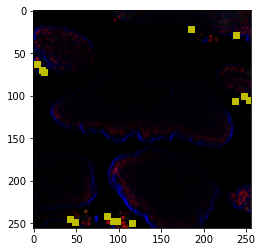

tensor([3.4867], device='cuda:0', grad_fn=<AddBackward0>)


In [211]:
sample = next(iter(data_loader_test))
outputs = model(sample['image'].float().to(device))
outputs_scores = torch.nn.functional.softmax(outputs['pred_logits'], -1)[:, :, 1][0]
outputs_points = outputs['pred_points'][0]

threshold = 0.45
# filter the predictions
points = outputs_points[outputs_scores > threshold].detach().cpu().numpy()
predict_cnt = int((outputs_scores > threshold).sum())
scores= outputs_scores[outputs_scores > threshold]

image_numpy = np.transpose(sample['image'][0], (1, 2, 0))
img_to_draw=image_numpy.numpy().copy() 

# draw the predictions
size = 40

plt.scatter(sample['landmarks'][0][:, 0], sample['landmarks'][0][:, 1], s=size, marker='s', c='y')

plt.scatter(points[:, 0], points[:, 1], s=size, marker='+', c='w')

plt.imshow(img_to_draw)
plt.show()

y_true=sample['landmarks']
y_pred= outputs['pred_points']

num_points = y_true.shape[1]
num_points = torch.as_tensor([num_points], dtype=torch.float).to(device)

idx = loss.match(y_pred,y_true)

class_loss=loss.loss_labels( outputs, y_true, idx, num_points)
coornidate_loss=loss.loss_points( outputs, y_true, idx, num_points)
losses = class_loss+coornidate_loss

print(class_loss+coornidate_loss)


In [188]:
sample['image'].shape

torch.Size([1, 3, 256, 256])

In [189]:
[dataset_test[i]['image'].to(device)]

[tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0078, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0127, 0.0020, 0.0029],
          [0.0000, 0.0000, 0.0000,  ..., 0.0265, 0.0039, 0.0118],
          ...,
          [0.0392, 0.0392, 0.0020,  ..., 0.0000, 0.0000, 0.0000],
          [0.0176, 0.0137, 0.0147,  ..., 0.0000, 0.0000, 0.0000],
          [0.0049, 0.0000, 0.0176,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0186, 0.0059, 0.0069],
          [0.0000, 0.0000, 0.0000,  ..., 0.0343, 0.0137, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0490, 0.0137, 0.0049],
          ...,
          [0.0265, 0.0245, 0.0392,  ..., 0.0000, 0.0000, 0.0000],
          [0.0059, 0.0078, 0.0167,  ..., 0.0000, 0.0000, 0.0000],
          [0.0020, 0.0000, 0.0010,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.3245, 0.3147, 0.2324],
          [0.0000, 0.0000, 0.0000,  ..., 0.1657, 0.1627, 0.1843],
          [0.0000, 0.0000, 0.0000,  ...,

In [190]:
output_coord

tensor([[[  1.6321,   3.7552],
         [  3.6792,   1.1808],
         [  3.3792,   6.7682],
         ...,
         [220.4503, 218.1567],
         [220.0538, 221.1366],
         [223.2200, 221.5525]]], device='cuda:0', grad_fn=<AddBackward0>)

In [191]:

def evaluate(data_loader_test):

    for sample in data_loader_test:
        
        outputs = model(sample['image'].float().to(device))

        y_true=sample['landmarks']
        y_pred= outputs['pred_points']
        
        num_points = y_true.shape[1]
        num_points = torch.as_tensor([num_points], dtype=torch.float).to(device)

        idx = loss.match(y_pred,y_true)

        class_loss=loss.loss_labels( outputs, y_true, idx, num_points)
        coornidate_loss=loss.loss_points( outputs, y_true, idx, num_points)
        
        return class_loss,coornidate_loss
        


In [192]:
eval_loss = evaluate(data_loader_test)
eval_loss

(tensor(0.1137, device='cuda:0', grad_fn=<NllLoss2DBackward>),
 tensor([4.2768], device='cuda:0', grad_fn=<DivBackward0>))

In [193]:
losses

tensor([3.2391], device='cuda:0', grad_fn=<AddBackward0>)

In [198]:
checkpoints_dir

'C:/Users/piyalong/TAMIDS_point/20230713/ckpts/'

# Transfer Learning

In [195]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [200]:
# Adam is used by default
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001 )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose =True)

writer = SummaryWriter('C:/Users/piyalong/TAMIDS_point/20230515_4/tensorboard/')

loss= Loss_function()
loss_history=[]

for name, param in model.named_parameters():
    # print(name, param.requires_grad )
    if 'regression.output' in name:
        param.requires_grad=True
        print(param.requires_grad )


    elif 'classification.output' in name:
        param.requires_grad=True
        print(param.requires_grad )
        
    else:
        param.requires_grad=False

# iterate all training samples
for epoch in range(10):
    model.train()
    print(get_lr(optimizer))
    t1 = time.time()
    for sample in data_loader_train:
      
        outputs = model(sample['image'].float().to(device))

        y_true=sample['landmarks']
        y_pred= outputs['pred_points']
        
        num_points = y_true.shape[1]
        num_points = torch.as_tensor([num_points], dtype=torch.float).to(device)

        idx = loss.match(y_pred,y_true)

        class_loss=loss.loss_labels( outputs, y_true, idx, num_points)
        coornidate_loss=loss.loss_points( outputs, y_true, idx, num_points)
        losses = class_loss+coornidate_loss
        # backward
        optimizer.zero_grad()
        losses.backward()
        # coornidate_loss.backward()
        optimizer.step()
        
        # print('epoch:{},coornidate_loss: {} ,class_loss: {}'.format(epoch,coornidate_loss,class_loss))

        if writer is not None:
            writer.add_scalar('loss/coornidate_loss', coornidate_loss, epoch)
            writer.add_scalar('loss/class_loss',class_loss, epoch)

        checkpoint_latest_path = os.path.join(checkpoints_dir, 'latest.pth')
        torch.save({
            'model': model.state_dict(),
        }, checkpoint_latest_path)
# evaluate and change learning rate and save best model
    model.eval()
    class_loss_eval,coornidate_loss_eval = evaluate(data_loader_test)
    loss_eval=class_loss_eval+coornidate_loss_eval
    loss_history.append(loss_eval.detach()) 
    print('epoch:{},coornidate_loss_eval: {} ,class_loss_eval: {}'.format(epoch,coornidate_loss_eval,class_loss_eval))

    if abs(np.min(loss_history[0].cpu().detach().numpy()) - loss_eval[0]) < 0.01:
        checkpoint_best_path = os.path.join(checkpoints_dir, 'best_mae.pth')
        torch.save({
            'model': model.state_dict(),
        }, checkpoint_best_path)    

    if writer is not None:
        writer.add_scalar('metric/coornidate_loss_eval', coornidate_loss_eval, epoch)
        writer.add_scalar('metric/class_loss_eval',class_loss_eval, epoch)    
    scheduler.step(loss_eval)
    

True
True
True
True
1e-05
epoch:0,coornidate_loss_eval: tensor([5.0469], device='cuda:0', grad_fn=<DivBackward0>) ,class_loss_eval: 0.01586979627609253
1e-05
epoch:1,coornidate_loss_eval: tensor([2.4077], device='cuda:0', grad_fn=<DivBackward0>) ,class_loss_eval: 0.03056134283542633
1e-05
epoch:2,coornidate_loss_eval: tensor([4.3366], device='cuda:0', grad_fn=<DivBackward0>) ,class_loss_eval: 0.08826866000890732
1e-05
epoch:3,coornidate_loss_eval: tensor([3.7120], device='cuda:0', grad_fn=<DivBackward0>) ,class_loss_eval: 0.03947019204497337
1e-05
epoch:4,coornidate_loss_eval: tensor([4.0756], device='cuda:0', grad_fn=<DivBackward0>) ,class_loss_eval: 0.07912994921207428
1e-05
epoch:5,coornidate_loss_eval: tensor([3.0410], device='cuda:0', grad_fn=<DivBackward0>) ,class_loss_eval: 0.029728086665272713
1e-05
epoch:6,coornidate_loss_eval: tensor([4.8543], device='cuda:0', grad_fn=<DivBackward0>) ,class_loss_eval: 0.017921460792422295
1e-05


RuntimeError: [enforce fail at ..\caffe2\serialize\inline_container.cc:262] . unexpected pos 22343936 vs 22343824

In [ ]:
for name, param in model.named_parameters():
    # print(name, param.requires_grad )
    if 'regression.output' in name:
        param.requires_grad=True
        print(param.requires_grad )


    elif 'classification.output' in name:
        param.requires_grad=True
        print(param.requires_grad )
        
    else:
        param.requires_grad=False

In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad )

In [ ]:
get_lr(optimizer)